# Network Analysis on Auckland road data
### Import packages

In [1]:
import numpy as np
import pandas as pd
import osmnx as ox
import geopandas as gpd
from shapely.geometry import MultiPolygon
from shapely.ops import transform
import pyproj
import networkx as nx
import math
import matplotlib.pyplot as plt
from pyproj import CRS
import itertools

### Importing territorial boundry of Auckland region

In [2]:
auckland_path = "data/geographic/territorial/auckland_polygon_diy.gpkg"
auckland = gpd.read_file(auckland_path)
auckland = auckland.to_crs(crs=4326)
polygonauck = auckland.iloc[0]['geometry']

In [3]:
waiheke_path = "data/geographic/territorial/waiheke_polygon.gpkg"
waiheke = gpd.read_file(waiheke_path)
waiheke = waiheke.to_crs(crs=4326)
polygonwaiheke = waiheke.iloc[0]['geometry']

### Generating the road network

In [4]:
Gwalk_auck = ox.graph.graph_from_polygon(polygonauck, network_type="walk", simplify=True, retain_all=True, truncate_by_edge=True)

In [5]:
Gwalk_auck.graph

{'created_date': '2023-03-22 18:14:54',
 'created_with': 'OSMnx 1.2.2',
 'crs': 'epsg:4326',
 'simplified': True}

In [6]:
# Add speed and travel time
Gwalk_auck = ox.add_edge_speeds(Gwalk_auck)
Gwalk_auck = ox.add_edge_travel_times(Gwalk_auck)
print("added all")

added all


In [7]:
Gwalk_waiheke = ox.graph.graph_from_polygon(polygonwaiheke, network_type="walk", simplify=True, retain_all=True, truncate_by_edge=True)
print("created")
Gwalk_waiheke = ox.add_edge_speeds(Gwalk_waiheke)
Gwalk_waiheke = ox.add_edge_travel_times(Gwalk_waiheke)
print("added all")

created
added all


In [10]:
Auckland_waiheke_walk = nx.compose(Gwalk_auck,Gwalk_waiheke)
Auckland_waiheke_walk = ox.project_graph(Auckland_waiheke_walk)
G = ox.simplification.consolidate_intersections(Auckland_waiheke_walk, rebuild_graph=True, tolerance=10, reconnect_edges=True)
ox.io.save_graph_geopackage(G, "data/network_analysis/auckland_waiheke_network_walkConsolidated.gpkg")

In [3]:
G = ox.io.load_graphml("data/network_analysis/auckland_waiheke_network_walk.graphml")

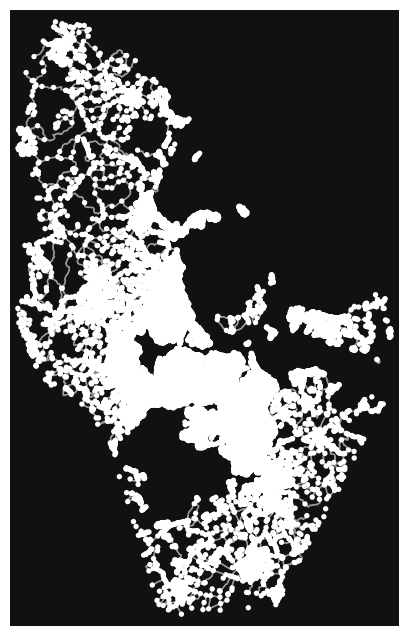

(<Figure size 800x800 with 1 Axes>, <AxesSubplot: >)

In [11]:
ox.plot.plot_graph(G)

Save for future use

### Consolidate the newtork to solve the spatial/topological issue

# Get 3-or-more-way intersections

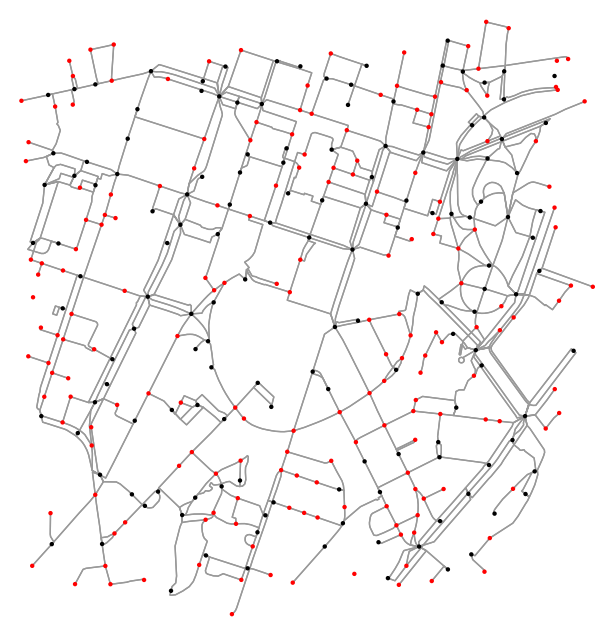

count:  187
stat:  187


In [23]:
G = ox.graph_from_address('Auckland, New Zealand', dist=500, network_type='walk', simplify=True, retain_all=True, truncate_by_edge=True)
G = ox.project_graph(G)
G = ox.simplification.consolidate_intersections(G, rebuild_graph=True, tolerance=10, reconnect_edges=True)

nc = []
count = 0
for n, d in G.nodes(data=True):
    if d['street_count'] >= 3:
        nc.append('#FF0000')
        count += 1
    else:
        nc.append('#000000')
stat = ox.stats.intersection_count(G, min_streets=2)
ox.plot_graph(G, node_size=10, bgcolor='#FFFFFF', node_color=nc, show=True, save=True, filepath='map.png')
print('count: ', count)
print('stat: ', stat)

# Bus Freqnecy from GTSF

In [6]:
df = pd.read_csv("data/transport/public_transport/GTFS/gtfs_auckland/stop_times.txt",sep=",", encoding="gbk")
df.drop(columns=df.columns[-4:], axis=1,  inplace=True)

In [ ]:
# sum bus departures from bus stops per day
df2 = df.groupby(by='stop_id').count().sort_values(by='arrival_time',ascending=False)

df2['busDepsPerHour'] = df2['departure_time']/24 # get average buses per hour
df2 = df2.loc[df2['busDepsPerHour'] >= 6] #select bus stops with more than 6 buses per hour, approximation of buses every 10 minutes

df2.to_csv("bus_frequency.csv") #save, joining with spatial bus stops was done in QGIS